In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:
file = '../data/processed/creditcard_balanced.csv'
data = pd.read_csv(file)

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,82450.0,1.314539,0.590643,-0.666593,0.716564,0.301978,-1.125467,0.388881,-0.288390,-0.132137,...,-0.170307,-0.429655,-0.141341,-0.200195,0.639491,0.399476,-0.034321,0.031692,0.76,0
1,50554.0,-0.798672,1.185093,0.904547,0.694584,0.219041,-0.319295,0.495236,0.139269,-0.760214,...,0.202287,0.578699,-0.092245,0.013723,-0.246466,-0.380057,-0.396030,-0.112901,4.18,0
2,55125.0,-0.391128,-0.245540,1.122074,-1.308725,-0.639891,0.008678,-0.701304,-0.027315,-2.628854,...,-0.133485,0.117403,-0.191748,-0.488642,-0.309774,0.008100,0.163716,0.239582,15.00,0
3,116572.0,-0.060302,1.065093,-0.987421,-0.029567,0.176376,-1.348539,0.775644,0.134843,-0.149734,...,0.355576,0.907570,-0.018454,-0.126269,-0.339923,-0.150285,-0.023634,0.042330,57.00,0
4,90434.0,1.848433,0.373364,0.269272,3.866438,0.088062,0.970447,-0.721945,0.235983,0.683491,...,0.103563,0.620954,0.197077,0.692392,-0.206530,-0.021328,-0.019823,-0.042682,0.00,0


In [4]:
X = data.drop(['Class', 'Amount', 'Time'], axis=1)
y = data['Class'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

c:\Users\David Cumaru\Desktop\CreditCard\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.compile(optimizer=Adam(learning_rate=0.001),  
              loss='binary_crossentropy',  
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])  

In [7]:
# Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [8]:
# Calculate class weights to help with imbalance
class_counts = data['Class'].value_counts()
weight_for_0 = 1.0
weight_for_1 = class_counts[0] / class_counts[1]
# Optionally scale down the weight for class 1 to avoid too high weights
weight_for_1 /= 10

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weights:', class_weight)

Class weights: {0: 1.0, 1: np.float64(0.1)}


In [9]:
# Train the model with early stopping
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=42,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    class_weight=class_weight)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6260 - auc: 0.6435 - loss: 0.7362 - val_accuracy: 0.8038 - val_auc: 0.7484 - val_loss: 0.9304
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7311 - auc: 0.7812 - loss: 0.5046 - val_accuracy: 0.8544 - val_auc: 0.8590 - val_loss: 0.8696
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8187 - auc: 0.8890 - loss: 0.4259 - val_accuracy: 0.8797 - val_auc: 0.9596 - val_loss: 0.6743
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8669 - auc: 0.9318 - loss: 0.3892 - val_accuracy: 0.9304 - val_auc: 0.9799 - val_loss: 0.5301
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8933 - auc: 0.9345 - loss: 0.3904 - val_accuracy: 0.9494 - val_auc: 0.9808 - val_loss: 0.4951
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9028 - auc: 0.9493 - loss: 0.3515 - val_accuracy: 0.9367 - val_auc: 0.9802 - val_loss: 0.5109
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

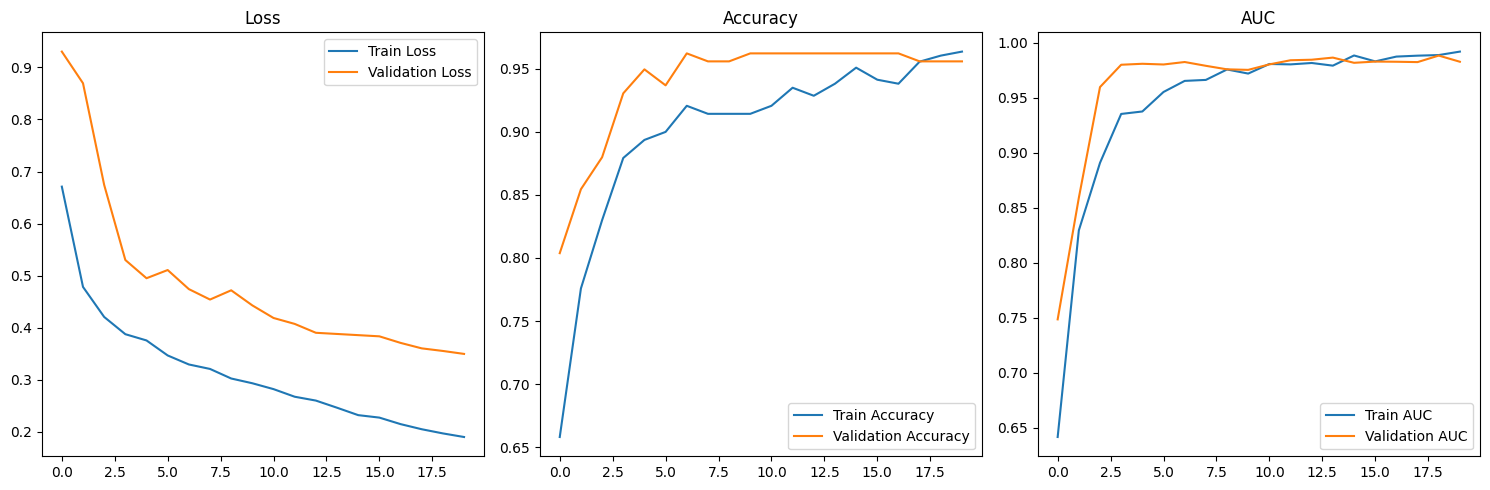

In [10]:
# Plot the training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Evaluate the model on the test set
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
print('Test Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))
print('Test AUC: {:.4f}'.format(test_auc))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9608 - auc: 0.9769 - loss: 0.3801 
Test Loss: 0.3324
Test Accuracy: 0.9645
Test AUC: 0.9842


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


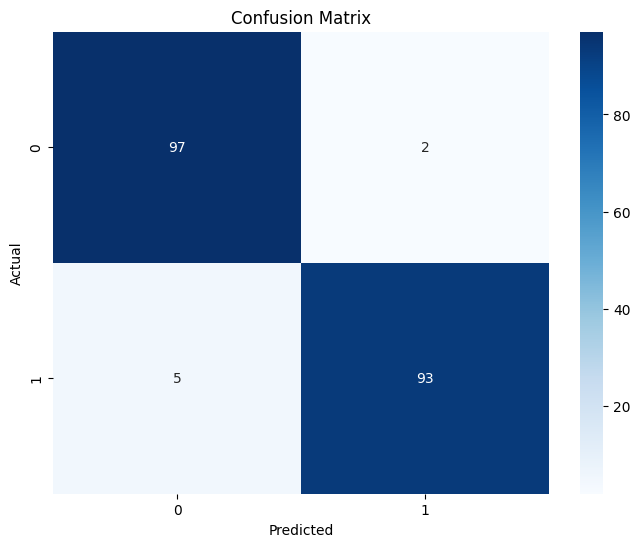

In [12]:
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        99
           1       0.98      0.95      0.96        98

    accuracy                           0.96       197
   macro avg       0.96      0.96      0.96       197
weighted avg       0.96      0.96      0.96       197

